In [1]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt

C:\Users\amirn\PycharmProjects\DS_builder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [4]:
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float32)
model.classifier = nn.Linear(model.classifier.in_features, 10)
model = model.to("cuda")

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")

C:\Users\amirn\PycharmProjects\DS_builder\.venv\Lib\site-packages\transformers\models\deit\feature_extraction_deit.py:30: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


## Dataset

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [7]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

100%|██████████| 170M/170M [00:39<00:00, 4.27MB/s] 


## Training

In [8]:
import torch.optim as optim

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [10]:
train_losses = []
train_accuracies = []

model.train()
for epoch in range(3):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        pil_images = [transforms.ToPILImage()(img) for img in images]
        inputs = extractor(images=pil_images, return_tensors="pt").to(device)
        labels = labels.to(device)

        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

100%|██████████| 3125/3125 [10:29<00:00,  4.96it/s]


Epoch 1: Loss = 0.1453, Accuracy = 95.35%


100%|██████████| 3125/3125 [10:29<00:00,  4.97it/s]


Epoch 2: Loss = 0.0565, Accuracy = 98.14%


100%|██████████| 3125/3125 [11:02<00:00,  4.71it/s]

Epoch 3: Loss = 0.0381, Accuracy = 98.76%


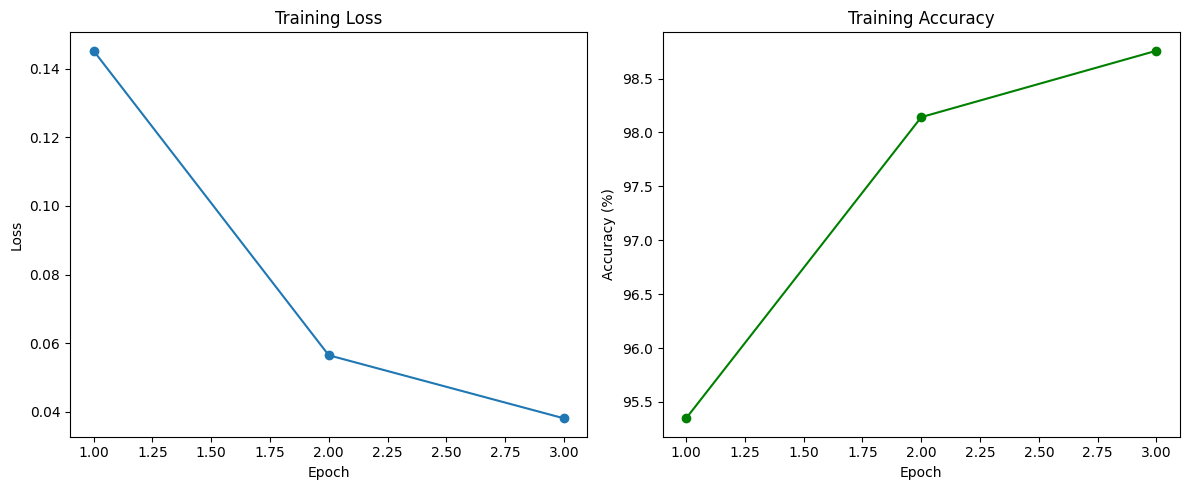

In [12]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()


## Test

In [13]:
test_dataset = datasets.CIFAR10(root='././data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in tqdm(test_loader):
        pil_images = [transforms.ToPILImage()(img) for img in x]
        inputs = extractor(images=pil_images, return_tensors="pt").to(device)
        y = y.to(device)

        outputs = model(**inputs)
        preds = outputs.logits.argmax(dim=1)

        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"\n🎯 Accuracy on CIFAR-10 test set: {100 * correct / total:.2f}%")

100%|██████████| 313/313 [00:59<00:00,  5.30it/s]


🎯 Accuracy on CIFAR-10 test set: 96.57%


# Distilliation

In [15]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Учитель
teacher = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224", torch_dtype=torch.float32
).to(device)

teacher.classifier = nn.Linear(teacher.classifier.in_features, 10).to(device)
teacher.eval()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [18]:
!pip install hf_xet

     ---------------------------------------- 2.7/2.7 MB 5.8 MB/s eta 0:00:00


In [26]:
from transformers import AutoFeatureExtractor, ViTForImageClassification

student = ViTForImageClassification.from_pretrained("facebook/deit-tiny-patch16-224").to(device)

student.classifier = nn.Linear(student.classifier.in_features, 10).to(device)

In [27]:
extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [28]:
def distillation_loss(student_logits, teacher_logits, true_labels, T=2.0, alpha=0.5):
    ce_loss = F.cross_entropy(student_logits, true_labels)
    kl_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction="batchmean"
    ) * (T * T)
    return alpha * ce_loss + (1 - alpha) * kl_loss

In [29]:
optimizer = optim.AdamW(student.parameters(), lr=5e-5)
num_epochs = 3

student.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        pil_images = [transforms.ToPILImage()(img) for img in images]
        inputs = extractor(images=pil_images, return_tensors="pt").to(device)
        labels = labels.to(device)

        with torch.no_grad():
            teacher_logits = teacher(**inputs).logits

        student_outputs = student(**inputs)
        student_logits = student_outputs.logits

        loss = distillation_loss(student_logits, teacher_logits, labels, T=2.0, alpha=0.7)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = student_logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


100%|██████████| 3125/3125 [06:29<00:00,  8.03it/s]


Epoch 1: Loss = 0.6071, Accuracy = 90.98%


100%|██████████| 3125/3125 [06:08<00:00,  8.48it/s]


Epoch 2: Loss = 0.5220, Accuracy = 95.62%


100%|██████████| 3125/3125 [13:47<00:00,  3.78it/s]

Epoch 3: Loss = 0.4983, Accuracy = 96.90%
